#GROWING CENTROID-POSSE PLOT

Damon Crockett, Software Studies Initiative, Qualcomm Institute, UCSD

In [271]:
category = "activities"

##CENTROID DATA

In [272]:
DIR = "/Users/damoncrockett/Desktop/cities_20k/yahoo/NEW_Clusters/Clusters_Normalized/"

In [273]:
DATA = DIR+"Normalized_Clustered/50/cluster_characterization_"+category+".csv"

In [274]:
import pandas as pd
df = pd.read_csv(DATA)
del df['Unnamed: 0']

##PCA

In [275]:
# note: PCA works MUCH better than t-SNE for this purpose

In [276]:
from sklearn.decomposition import RandomizedPCA as pca
pca = pca(n_components=2)
X = df.as_matrix()
pca.fit(X)
subspace = pd.DataFrame(pca.transform(X),columns=["x","y"])

In [277]:
%matplotlib inline
import matplotlib.pyplot as plt

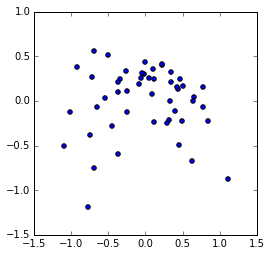

In [278]:
x = subspace.x
y = subspace.y
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

##IMAGE DATA

In [279]:
BASE = "/Users/damoncrockett/Desktop/cities_20k/"

In [280]:
import os
import glob

####ADD LOCAL PATHS

In [281]:
"""
for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    tmp = pd.read_csv(file)
    n = len(tmp.index)
    local_path = []
    for i in range(n):
        local_path.append(BASE+os.path.basename(file).split("_")[0]+"_20k/"+tmp.ad_id.loc[i]+".jpg")
    tmp['local_path'] = local_path
    tmp.to_csv(file,index=False)
"""

'\nfor file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):\n    tmp = pd.read_csv(file)\n    n = len(tmp.index)\n    local_path = []\n    for i in range(n):\n        local_path.append(BASE+os.path.basename(file).split("_")[0]+"_20k/"+tmp.ad_id.loc[i]+".jpg")\n    tmp[\'local_path\'] = local_path\n    tmp.to_csv(file,index=False)\n'

####SUBSET TO COLUMNS IN CLUSTER CATEGORY

In [282]:
counter=-1

for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    counter+=1
    tmp = pd.read_csv(file)
    columns = list(df.columns.values)
    columns.append("ad_id")
    columns.append("local_path")
    tmp = tmp[columns]
    if counter==0:
        collection = tmp
    else:
        collection = collection.append(tmp)

In [283]:
collection.dropna(inplace=True)

####ADD CLUSTER LABELS

In [284]:
label_df = pd.read_csv(DIR+"Normalized_Cluster_Labels/50/"+category+".csv")
label_df.rename(columns={"image_id":"ad_id"},inplace=True)
label_df = label_df[["ad_id","cluster_id"]]
label_df.set_index("ad_id",inplace=True)

In [285]:
collection = collection.join(label_df,on="ad_id")

In [286]:
collection = collection[collection.cluster_id.notnull()]

In [287]:
collection.reset_index(drop=True,inplace=True)

####EUCLIDEAN DISTANCE FROM CENTROID

In [288]:
import numpy as np

In [289]:
euclidean_distance = []

n = len(collection.index)
for i in range(n):
    tmp = collection.iloc[i].as_matrix()
    cluster_integer = int(collection.cluster_id.loc[i])
    m = len(tmp) - 3
    tmp = tmp[:m]
    
    # note: df is zero-indexed but cluster labels are 1-indexed
    euclidean_distance_i = np.linalg.norm(tmp - df.iloc[cluster_integer - 1].as_matrix())
    euclidean_distance.append(euclidean_distance_i)

In [290]:
collection['euclidean_distance'] = euclidean_distance

In [291]:
collection = collection[['local_path','cluster_id','euclidean_distance']]

##GRID

In [292]:
num_bins = 100

In [293]:
# adding in some extremes to push the edges out

print subspace.x.min(), subspace.x.max(), subspace.y.min(), subspace.y.max()

-1.09937186767 1.11783899808 -1.18573609755 0.555882936298


In [294]:
x = [-1.5,1.5]
y = [-1.5,1]

tmp = pd.DataFrame(x,columns=["x"])
tmp["y"] = y
subspace = subspace.append(tmp)

In [295]:
subspace['x_bin'] = pd.cut(subspace['x'],num_bins,labels=False)
subspace['y_bin'] = pd.cut(subspace['y'],num_bins,labels=False)

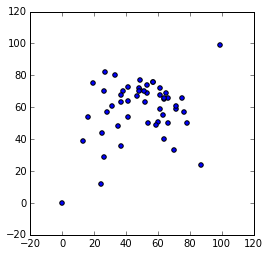

In [296]:
x = subspace.x_bin
y = subspace.y_bin
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

In [297]:
# now we can remove the extreme points we used as grid expanders

subspace = subspace[:50]

In [298]:
# now to expand the grid by simple multiplication

factor = 1

subspace["x_grid"] = subspace.x_bin * factor
subspace["y_grid"] = subspace.y_bin * factor

In [299]:
from shapely.geometry import Point

centroid_point = []
n = len(subspace.index)
for i in range(n):
    centroid_point.append(Point(subspace.x_grid.loc[i],subspace.y_grid.loc[i]))
    
subspace['centroid_point'] = centroid_point

####GRID LIST

In [300]:
grid_side = num_bins * factor

In [301]:
x,y = range(grid_side) * grid_side, np.repeat(range(grid_side),grid_side)
grid_list = pd.DataFrame(x,columns=['x'])
grid_list['y'] = y

In [302]:
point = []
n = len(grid_list.index)
for i in range(n):
    point.append(Point(grid_list.x.loc[i],grid_list.y.loc[i]))

grid_list['point'] = point

In [303]:
open_grid = list(grid_list.point)

In [304]:
centroids = list(subspace.centroid_point)

####REMOVAL OF CENTROIDS FROM OPEN_GRID LIST

In [305]:
len(open_grid)

10000

In [306]:
len(centroids)

50

In [307]:
# note that this will have the effect that, in the plot, the centroid locations will be empty

In [308]:
open_grid = [item for item in open_grid if item not in centroids]

In [309]:
len(open_grid)

9951

##PLOT FUNCTION

In [310]:
from PIL import Image

In [311]:
thumb_side = 64

In [312]:
px_w = thumb_side * grid_side
px_h = thumb_side * grid_side

In [313]:
canvas = Image.new('RGB',(px_w,px_h),(50,50,50))

In [314]:
def plot():
    n = len(subspace.index)
    for i in range(n):
        centroid = subspace.centroid_point.loc[i]
        try:
            # again, a workaround for indexing difference
            candidates = collection[collection.cluster_id==i+1]
            candidates.sort("euclidean_distance",inplace=True)
            best = candidates.iloc[0]
            im = Image.open(best.local_path)
            im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
            closest_open = min(open_grid,key=lambda x: centroid.distance(x))
            x = int(closest_open.x) * thumb_side
            y = int(closest_open.y) * thumb_side
            canvas.paste(im,(x,y))
            idx = collection[collection.local_path==best.local_path].index
            collection.drop(idx,inplace=True)
            open_grid.remove(closest_open)
            print i
        except:
            print "cluster empty"

In [315]:
iterations = list(collection.cluster_id.value_counts())[0]

In [316]:
for i in range(iterations):
    print "plot_",i
    plot()

plot_ 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
plot_ 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
cluster empty
42
43
44
45
46
47
48
49
plot_ 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
cluster empty
42
43
44
45
46
47
48
49
plot_ 5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
cluster empty
42
43
44
45
46
47
48
49
plot_ 6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [317]:
canvas.save("/Users/damoncrockett/Desktop/entourage_plots/"+category+".png")